# **Buy Till You Die Models: Customer Lifetime Value**

<p><img style="float: left;margin:20px 10px 5px 1px; max-width:380px" src="https://i.ytimg.com/vi/l_xwYM2KNX0/maxresdefault.jpg"></p>
<p> The Buy Till You Die (BTYD) class of statistical models is designed to predict the behavioral characteristics of customers. The main purpose is to model and forecast customer lifetime value. </p>
<p> Customer lifetime value (CLTV or CLV) can be defined as the present value of a customer for the company based on projected future cash flows from the customer relationship. CLTV represents the total amount of money spent on the business or products over lifetime of a customer.</p>
<p> In this notebook, I'll try to apply a BTYD model on an online retail dataset to make a 1-year CLTV prediction.</p> 
<p> For more information about CLV, check https://www.araoo.fr/blog/data-conversion/cutomer-lifetime-value/ </p>

## 1. Loading the Dataset & Checking Variables


### ****Content of Dataset****

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Source:

    https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository
    https://archive.ics.uci.edu/ml/datasets/Online+Retail+II


### ****Definiton of Variables****
1. **Invoice:** Invoice number, unique identifier variable for each transaction. Refund invoice numbers starts with "C"
2. **StockCode:** Unique product code
3. **Description:** Product name
4. **Quantity:** The number of product in the invoice
5. **InvoiceDate:** Date and time of the purchase
6. **Price:** Unit price of a product (in terms of Sterlin)
7. **CustomerID:** Unique customer identifier
8. **Country:** Residential country of customers

In [2]:
pip install openpyxl
pip install xlrd
pip install lifetimes
# Successor of lifetimes -> pip install btyd

  Using cached openpyxl-3.0.10-py2.py3-none-any.whl (242 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [25]:
# Loading the required libraries
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

from os import path

In [23]:
# Download dataset
import requests
from tqdm import tqdm

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in tqdm(response.iter_content(CHUNK_SIZE)):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [51]:
if not path.exists("online_retail_II.xlsx"):
    # Another option to download is gdown -> "pip install gdown"
    download_file_from_google_drive("1A5H4fZ38NxWLyX7wedINghC1iPRb9LzD", "online_retail_II.xlsx")

In [62]:
# Reading the online retail dataset
df_ = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")

In [80]:
# Copying the online retail dataset 
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [81]:
# Checking numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


<p> When we look at the descriptive statistics of numerical variables, we can see that there are negative values in the Quantity and Price columns. These transactions are canceled orders. In the next step (data preprocessing), we'll eliminate these observations.

In [82]:
# Checking null variables 
df.isna().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

There are null observations in the dataset, especially in the Customer ID column. Since this analysis will be consumer-based, we need to remove these observations from the dataset. Therefore, we will  eliminate these observations in the next step (data preprocessing).

## 2. Data Preprocessing

In [83]:
# Data preparation step 1: Removing null oberservations
df.dropna(inplace=True)

# Data preparation step 1: Removing canceled orders 
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

df.describe([0.01,0.25,0.50,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Quantity,397925.0,13.021793,180.419984,1.0,1.00,2.00,6.00,12.00,120.00,80995.00
Price,397925.0,3.116212,22.096773,0.0,0.21,1.25,1.95,3.75,14.95,8142.75
Customer ID,397925.0,15294.308601,1713.172738,12346.0,12415.00,13969.00,15159.00,16795.00,18211.00,18287.00


<p>Check out descriptive statistics of numerical variables again! Look at 99% quantile of Quantity and Price columns and compare with the maximum values. We can say that there are some outliers.</p>
<p>Let's find out these outliers and replace them with the highest limit.</p>

In [84]:
# Defining functions for outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Defining functions to replace outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [85]:
# Data preparation step 2: Replacing outliers in the Quantity and Price columns with the upper limit
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

df.describe([0.01,0.25,0.50,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Quantity,397925.0,11.833709,25.534486,1.0,1.00,2.00,6.00,12.00,120.00,298.50
Price,397925.0,2.893201,3.227143,0.0,0.21,1.25,1.95,3.75,14.95,37.06
Customer ID,397925.0,15294.308601,1713.172738,12346.0,12415.00,13969.00,15159.00,16795.00,18211.00,18287.00


In [86]:
# Data preparation step 3: Calculating total price per transaction 
df["TotalPrice"] = df["Quantity"] * df["Price"]
today_date = dt.datetime(2011, 12, 11)

In [87]:
# Defining today date as max(InvoiceDate) + 2 days
today_date = dt.datetime(2011, 12, 11)
print(f" Maximum invoice date: {df.InvoiceDate.max()} \n Today date: {today_date}")

 Maximum invoice date: 2011-12-09 12:50:00 
 Today date: 2011-12-11 00:00:00


## 3. Deriving the RFM Metrics

<p><img style="float: right;margin:-10px 20px 20px 5px; max-width:380px" src="https://www.retailreco.com/blog/wp-content/uploads/2018/11/RFM-Analytics.jpg"></p>

The predictive CLTV models are built around 4 key metrics. These are:

**<p>Recency:**  The age of the customer at the time of their last purchase.
**<p>Monetary:** The average total sales of the customer.
**<p>Frequency:** Number of purchases/transactions.
**<p>Age (T):** The age of the customer since the date of a customer's first purchase to the current date.

In [88]:
# Calculating recency, monetary, frequency and tenure metrics
rfm = df.groupby("Customer ID").agg({"InvoiceDate": [lambda date: (date.max() - date.min()).days,
                                                     lambda date: (today_date - date.min()).days],
                                     "Invoice": lambda num: num.nunique(),
                                      "TotalPrice": lambda price: price.sum()}) #total price per customer

# Because group by created a second level with name <lambda> 
rfm.columns = rfm.columns.droplevel(0)
# Rename lambdas
rfm.columns = ['Recency', "T", 'Frequency', "Monetary"]

# Calculating average monetary values per order:
rfm["Monetary"] = rfm["Monetary"] / rfm["Frequency"]

rfm.head()

,Recency,T,Frequency,Monetary
Customer ID,,,,
12346.0,0,326,1,310.440000
12347.0,365,368,7,615.714286
12348.0,282,359,4,442.695000
12349.0,0,19,1,1491.720000
12350.0,0,311,1,331.460000


In [89]:
# Removing one-time purchases from dataset
rfm = rfm[(rfm['Frequency'] > 1)]

# Copying dataset
cltv = rfm.copy()
rfm.head()

,Recency,T,Frequency,Monetary
Customer ID,,,,
12347.0,365,368,7,615.714286
12348.0,282,359,4,442.695000
12352.0,260,297,8,219.542500
12356.0,302,326,3,937.143333
12358.0,149,151,2,575.210000


# 4. Train BG-NBD Model (Expected number of transaction)

In this step, we will train the BG/NBD model to estimate the expected sales in a given period of time.
Also, the trained BG/NBD model will be used in predicting customer lifetime value in the following steps. 

In [90]:
# Loading the required libraries
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix

In [91]:
# Checking BG/NBD model assumption and requirements
print(cltv[['Monetary', 'Recency']].corr())  # Correlation between monetary ve recency variables
cltv["Frequency"] = cltv["Frequency"].astype(int) # Type of frequency variable should be integer for BG-NBD model

          Monetary  Recency
Monetary   1.00000  0.09337
Recency    0.09337  1.00000


In [92]:
# Creating BG-NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.001) # model object
bgf.fit(cltv['Frequency'], cltv['Recency'], cltv['T']) # model fitting

# Prediction of expected number of transaction for each customer for one year (365 days)
cltv['expctd_num_of_purch'] = bgf.predict(365, cltv['Frequency'], cltv['Recency'], cltv['T']) 
cltv.sort_values("expctd_num_of_purch",ascending=False).head()

,Recency,T,Frequency,Monetary,expctd_num_of_purch
Customer ID,,,,,
12748.0,372,374,210,154.192429,164.006741
14911.0,372,374,201,691.710100,157.048730
17841.0,371,374,124,330.134355,97.454047
13089.0,366,370,97,606.362474,77.200939
14606.0,372,374,93,130.139032,73.528328


Look at the new columns that we estimate average spending for each customer in a year. By using this information, you can make many business decisions!

This model can also estimate the retention rate and the probability of the customer is alive. Let's plot the probability matrix together and see what will happen!

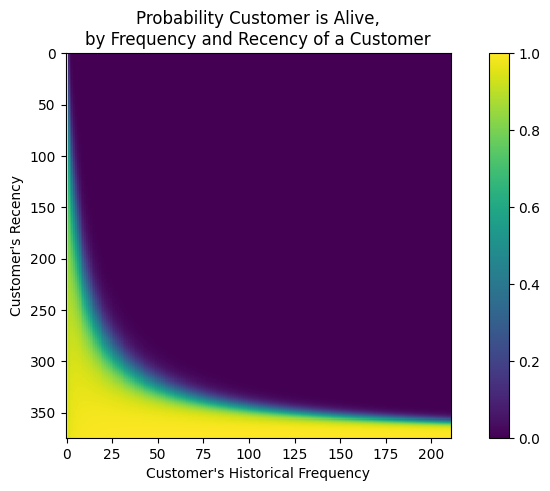

In [93]:
%matplotlib inline
# set figure size
plt.subplots(figsize=(10, 5))
plot_probability_alive_matrix(bgf)
plt.show()

# 5. Train Gamma Gamma Model (Expected average spending)

Now, we will train the gamma-gamma model to estimate average spending for future transactional events. Then, it will be used for calculating the customer lifetime value. 

In [94]:
# Creating Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef=0.01) # model object
ggf.fit(cltv['Frequency'], cltv['Monetary']) # model fitting

# Prediction of expected amount of average profit
cltv["expct_avg_spend"] = ggf.conditional_expected_average_profit(cltv['Frequency'], cltv['Monetary'])

cltv.head()

,Recency,T,Frequency,Monetary,expctd_num_of_purch,expct_avg_spend
Customer ID,,,,,,
12347.0,365,368,7,615.714286,7.081226,631.911974
12348.0,282,359,4,442.695000,4.602317,463.745539
12352.0,260,297,8,219.542500,9.090603,224.886669
12356.0,302,326,3,937.143333,4.298322,995.997679
12358.0,149,151,2,575.210000,5.953164,631.900951


## 6. Final: Calculate CLTV

In [95]:
# Calculating customer lifetime value by using BG-NBD and GammaGamma models: 

cltv["cltv_one_year"] = ggf.customer_lifetime_value(bgf,
                                   cltv['Frequency'],
                                   cltv['Recency'],
                                   cltv['T'],
                                   cltv['Monetary'],
                                   time=12,  # 12 month
                                   freq="D",  # frequency of T
                                   discount_rate=0.01)

cltv.sort_values("cltv_one_year",ascending=False).head()

,Recency,T,Frequency,Monetary,expctd_num_of_purch,expct_avg_spend,cltv_one_year
Customer ID,,,,,,,
14646.0,353,355,74,3596.804392,61.316101,3605.309159,204735.095545
18102.0,366,368,60,3859.739083,48.623095,3870.996702,174313.470352
14096.0,97,102,17,3163.588235,35.234619,3196.435385,104394.666897
12415.0,313,338,21,5724.302619,19.005586,5772.177190,101605.295723
14911.0,372,374,201,691.710100,157.048730,692.326355,100694.105622


<p>Together, we get the most valuable five customers for a year! </p>
<p>This model is capable of producing valuable information to be used for several purposes by various departments such as marketing, sales, and product development. By using it, we can simply create segments according to the CLTV. We can also extract the least valuable customers and send them to customer relationship management to increase customer engagement with the company.

Thank you for making it to the very end of this notebook!

Please feel free to leave a comment to improve it together. 